<a href="https://colab.research.google.com/github/5ohyun/Stock_SSPharm/blob/main/%EC%82%BC%EC%84%B1%EC%A0%9C%EC%95%BD_%EC%98%88%EC%B8%A1_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- Package install

In [2]:
!pip install catboost
!pip install category_encoders

     |████████████████████████████████| 69.2 MB 5.2 kB/s 
     |████████████████████████████████| 80 kB 4.1 MB/s 


In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (7,014 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and d

In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import itertools

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from catboost import CatBoostClassifier, Pool


from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


In [5]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

sns.set_palette("Set3")

### 변수 설명

**19개의 열과 반응 변수 y (Credit)**


* index : 인덱스
* gender: 성별
* car: 차량 소유 여부
* reality: 부동산 소유 여부
* child_num: 자녀 수
* income_total: 연간 소득

* income_type: 소득 분류

    ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']



* edu_type: 교육 수준

    ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']



* family_type: 결혼 여부

    ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']



* house_type: 생활 방식

    ['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']



* DAYS_BIRTH: 출생일

    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미



* DAYS_EMPLOYED: 업무 시작일

    데이터 수집 당시 (0)부터 역으로 
    즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미
    양수 값은 고용되지 않은 상태를 의미함



* FLAG_MOBIL: 핸드폰 소유 여부


* work_phone: 업무용 전화 소유 여부


* phone: 전화 소유 여부


* email: 이메일 소유 여부


* occyp_type: 직업 유형													


* family_size: 가족 규모


* begin_month: 신용카드 발급 월
			
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미







* credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도

    낮을 수록 높은 신용의 신용카드 사용자를 의미함

	



### 데이터 로드

In [6]:
os.chdir('/content/drive/MyDrive/신용카드/')

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

In [7]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [8]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0
9996,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0
9997,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0
9998,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0


### 데이터 정제

- 'occyp_type' 직업 유형 정보가 소실되어 있음을 확인

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


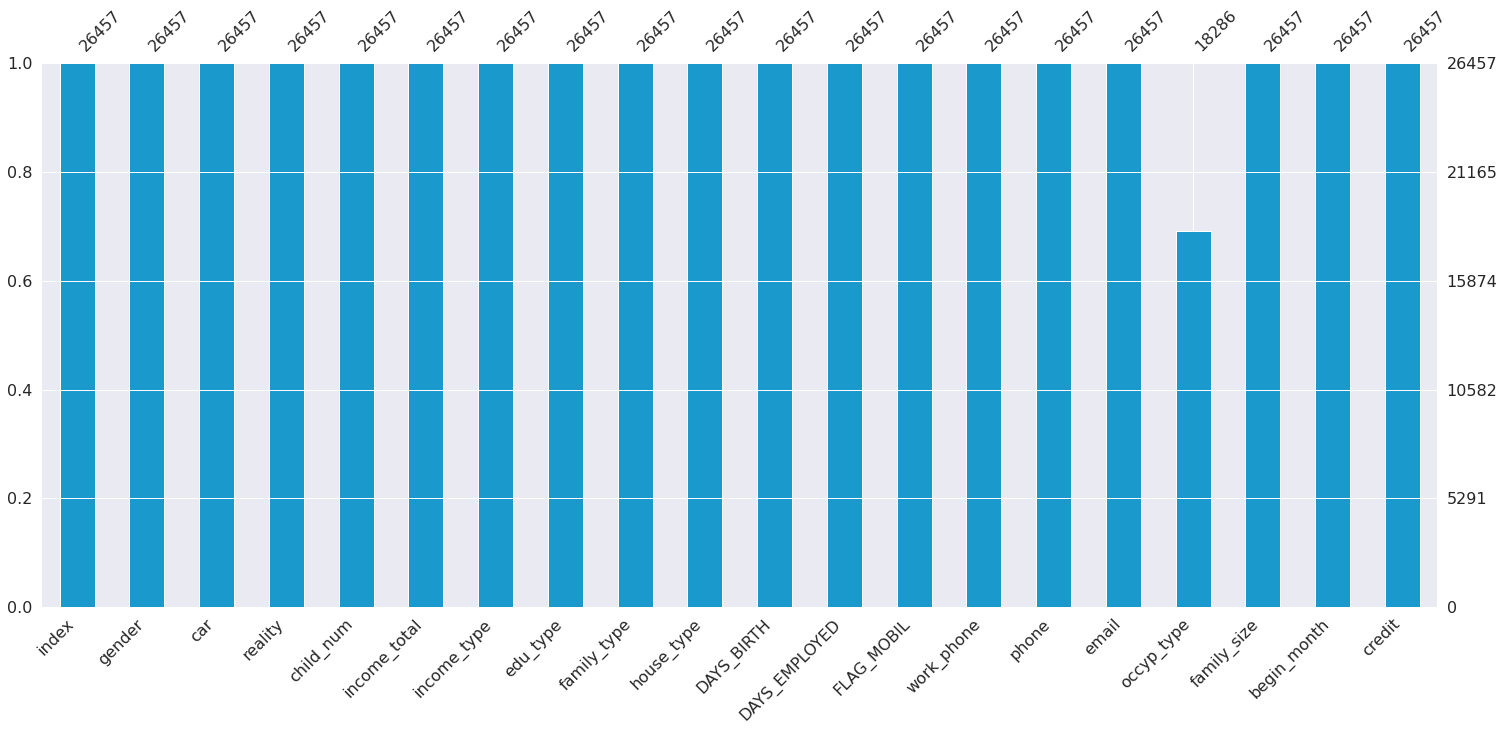

In [9]:
import missingno as msno
msno.bar(df=train.iloc[:, :], color=(0.1, 0.6, 0.8))

- 음수로 나타나있는 변수 -> 양수로 변경

In [10]:
variable = ['DAYS_BIRTH','DAYS_EMPLOYED','begin_month']

train[variable]=-train[variable]
test[variable]=-test[variable]

- 데이터 분포 확인

In [11]:
for i in train.columns :
    print(train[i].value_counts())
    print('---------------------')

2047     1
5448     1
3371     1
13612    1
15661    1
        ..
2740     1
693      1
6838     1
4791     1
0        1
Name: index, Length: 26457, dtype: int64
---------------------
F    17697
M     8760
Name: gender, dtype: int64
---------------------
N    16410
Y    10047
Name: car, dtype: int64
---------------------
Y    17830
N     8627
Name: reality, dtype: int64
---------------------
0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64
---------------------
135000.0    3164
157500.0    2233
180000.0    2225
112500.0    2178
225000.0    2170
            ... 
177750.0       1
91530.0        1
87448.5        1
97731.0        1
204750.0       1
Name: income_total, Length: 249, dtype: int64
---------------------
Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64
--------

In [12]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,15958.053899,-59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,7705.000000,-365243.000000,1.0,0.000000,0.000000,0.000000,1.000000,-0.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,12446.000000,407.000000,1.0,0.000000,0.000000,0.000000,2.000000,12.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,15547.000000,1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,19431.000000,3153.000000,1.0,0.000000,1.000000,0.000000,3.000000,39.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,25152.000000,15713.000000,1.0,1.000000,1.000000,1.000000,20.000000,60.000000,2.000000


- 인덱스 컬럼 삭제
- 데이터가 모두 1로 이루어져 있는 FLAG_MOBIL 컬럼 삭제

In [13]:
train = train.drop(columns=['index','FLAG_MOBIL'])
test = test.drop(columns=['index','FLAG_MOBIL'])

- 고용된 날짜가 0보다 작으면 무직인 상태로 간주

In [14]:
train['DAYS_EMPLOYED']= train['DAYS_EMPLOYED'].map(lambda x: 0 if x<=0 else x)
test['DAYS_EMPLOYED']= test['DAYS_EMPLOYED'].map(lambda x: 0 if x<=0 else x)

- 나이변수 생성

In [15]:
train['age']=train['DAYS_BIRTH']/365
train['age'] = train['age'].astype('int')

test['age']=test['DAYS_BIRTH']/365
test['age'] = test['age'].astype('int')


- 1634개의 중복행 확인

In [16]:
duplicateDFRow = train[train.duplicated()]
duplicateDFRow

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age
419,M,Y,Y,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,18820.0,3185.0,0,1,0,Low-skill Laborers,2.0,7.0,1.0,51
716,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,21497.0,0.0,0,0,0,NaN,1.0,4.0,1.0,58
877,M,Y,N,2,180000.0,State servant,Secondary / secondary special,Married,House / apartment,12240.0,4663.0,0,0,0,Core staff,4.0,24.0,2.0,33
1056,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Married,House / apartment,24665.0,0.0,0,0,0,NaN,2.0,35.0,2.0,67
1315,F,Y,Y,0,130500.0,Working,Secondary / secondary special,Married,House / apartment,16137.0,9391.0,0,1,0,Laborers,2.0,29.0,2.0,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26374,F,Y,N,0,112500.0,Working,Secondary / secondary special,Married,Municipal apartment,17372.0,978.0,0,1,0,Sales staff,2.0,15.0,1.0,47
26393,M,Y,Y,0,247500.0,Working,Secondary / secondary special,Married,House / apartment,14122.0,3383.0,0,0,0,Managers,2.0,31.0,2.0,38
26428,F,Y,Y,2,270000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,12745.0,525.0,0,0,1,Core staff,4.0,23.0,1.0,34
26446,F,N,Y,0,135000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,16300.0,9698.0,0,0,1,Managers,2.0,41.0,2.0,44


### 범주형 변수 시각화

(1) 신용 등급 비율

- 낮은 등급의 신용카드 사용자가 많다

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


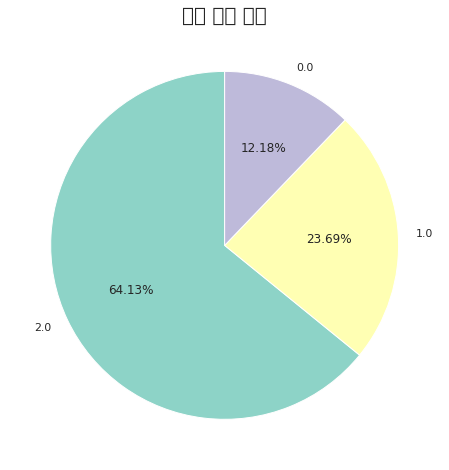

In [17]:
plt.subplots(figsize = (8,8))
plt.pie(train['credit'].value_counts(), labels = train['credit'].value_counts().index, 
        autopct="%.2f%%", startangle = 90)
plt.title('신용 등급 비율', size=20)
plt.show()

In [18]:
def bar_chart(data,feature):
  credit_0 = data[data['credit']==0][feature].value_counts(normalize=True)
  credit_1 = data[data['credit']==1][feature].value_counts(normalize=True)
  credit_2 = data[data['credit']==2][feature].value_counts(normalize=True)

  df = pd.DataFrame([credit_0,credit_1,credit_2])
  df.index = ['credit_0','credit_1','credit_2']
  df = df.T
  df = df.reset_index()
  
  df.plot(x='index',kind='barh',stacked=True, title=feature, mark_right = True,figsize=(16, 6))

  df_total = df["credit_0"] + df["credit_1"] + df["credit_2"]
  df_rel = df[df.columns[1:]].div(df_total, 0) * 100
    
  for n in df_rel:
      for i, (cs, ab, pc) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], 
                                          df[n], df_rel[n])):
          plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
                  va = 'center', ha = 'center', rotation = 0, fontsize = 8)

(2) 신용 등급과 성별

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


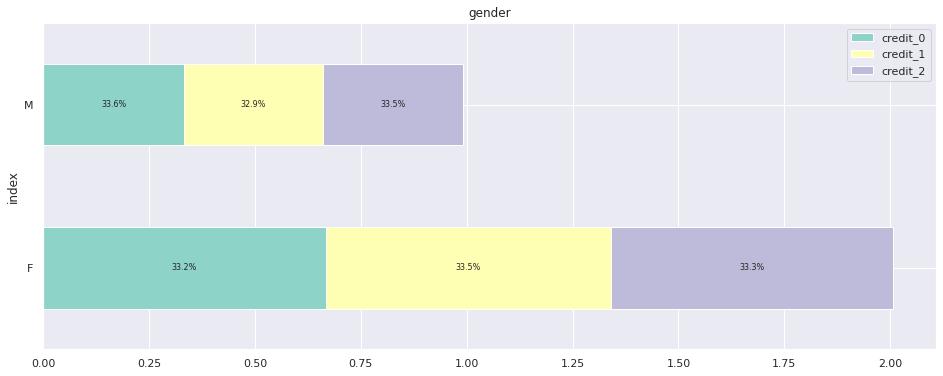

In [19]:
bar_chart(train,'gender')

- 모든 등급에서 여성이 더 많으며, 성별에 따른 신용 등급의 차이는 보이지 않는다.

(3) 신용 등급과 부동산 소유

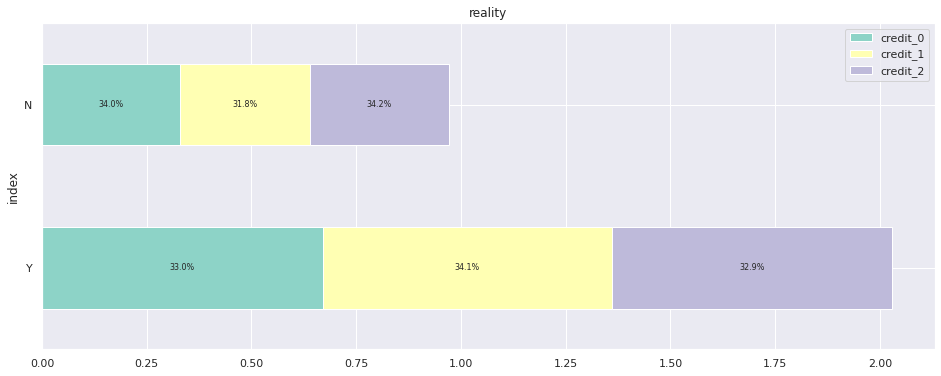

In [20]:
bar_chart(train,'reality')

- 모든 등급에서 부동산을 소유하고 있는 사람들이 많으며, 부동산 소유에 따른 신용 등급의 차이는 보이지 않는다

(4) 신용 등급과 자차 소유

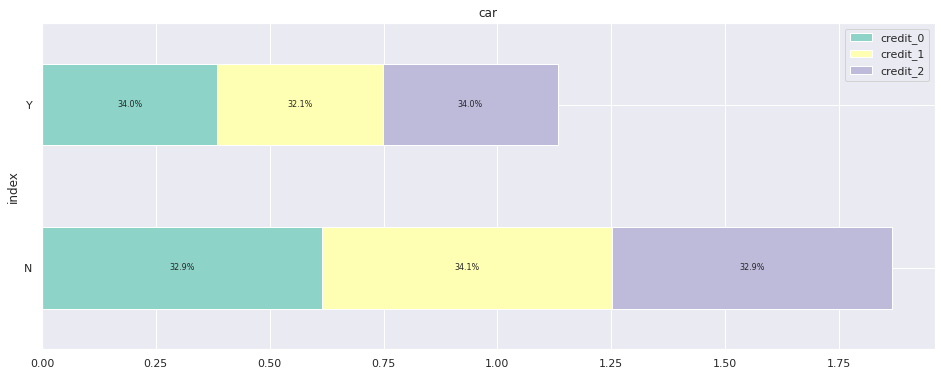

In [21]:
bar_chart(train,'car')

* 모든 등급에서 차를 소유하고 있지 않은 사람들이 많으며, 차의 소유와 신용 등급의 차이는 보이지 않는다.


(5) 신용 등급과 소득 분류

In [22]:
def multicat_plot(data,feature):

  f, ax = plt.subplots(1, 3, figsize=(16, 6))

  credit_0 = data[data['credit']==0]
  credit_1 = data[data['credit']==1]
  credit_2 = data[data['credit']==2]

  
  sns.countplot(x = feature,
                data = credit_0,
                ax = ax[0],
                order = credit_0[feature].value_counts().index) # 큰 수부터 정렬
  
  
  ax[0].tick_params(labelsize=12)
  ax[0].set_title('credit_0')
  ax[0].set_ylabel('count')
  ax[0].tick_params(axis='x',rotation=50)

  for p in ax[0].patches:
    ax[0].annotate(f'\n{p.get_height()}', (p.get_x()+0.1, p.get_height()+70), color='black', size=12)


  sns.countplot(x = feature,
                data = credit_1,
                ax = ax[1],
                order = credit_1[feature].value_counts().index) 
  
  
  ax[1].tick_params(labelsize=12)
  ax[1].set_title('credit_1')
  ax[1].set_ylabel('count')
  ax[1].tick_params(axis='x', rotation=50)

  for p in ax[1].patches:
    ax[1].annotate(f'\n{p.get_height()}', (p.get_x()+0.1, p.get_height()+70), color='black', size=12)

  sns.countplot(x = feature,
                data = credit_2,
                ax = ax[2],
                order = credit_2[feature].value_counts().index)
  
  
  ax[2].tick_params(labelsize=12)
  ax[2].set_title('credit_2')
  ax[2].set_ylabel('count')
  ax[2].tick_params(axis='x',rotation=50)

  plt.subplots_adjust(wspace=0.2, hspace=0.3)
  
  for p in ax[2].patches:
    ax[2].annotate(f'\n{p.get_height()}', (p.get_x()+0.1, p.get_height()+70), color='black', size=12)
  plt.show()


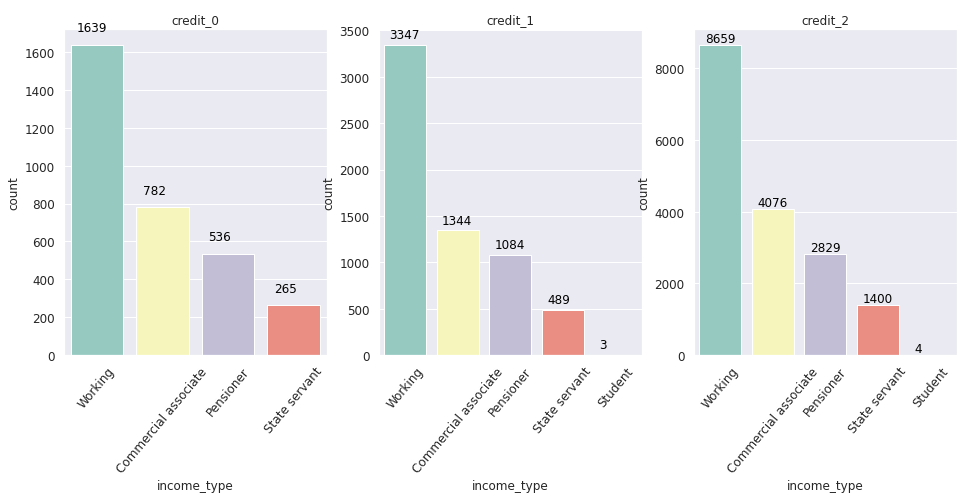

In [23]:
multicat_plot(train, 'income_type')

- 신용 등급이 0인 분류에는 학생이 존재하지 않음 > 신용 등급에 따른 소득 분류 차이 존재함으로 보임

(6) 신용 등급과 교육 수준

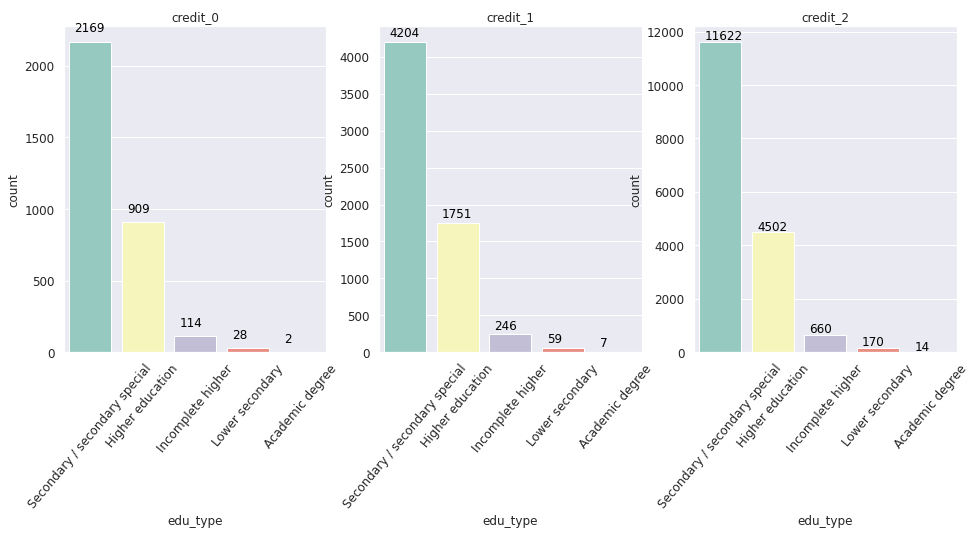

In [24]:
multicat_plot(train, 'edu_type')

* 신용 등급에 따른 교육 수준은 유사해 보인다.


(7) 신용 등급과 가족 유형

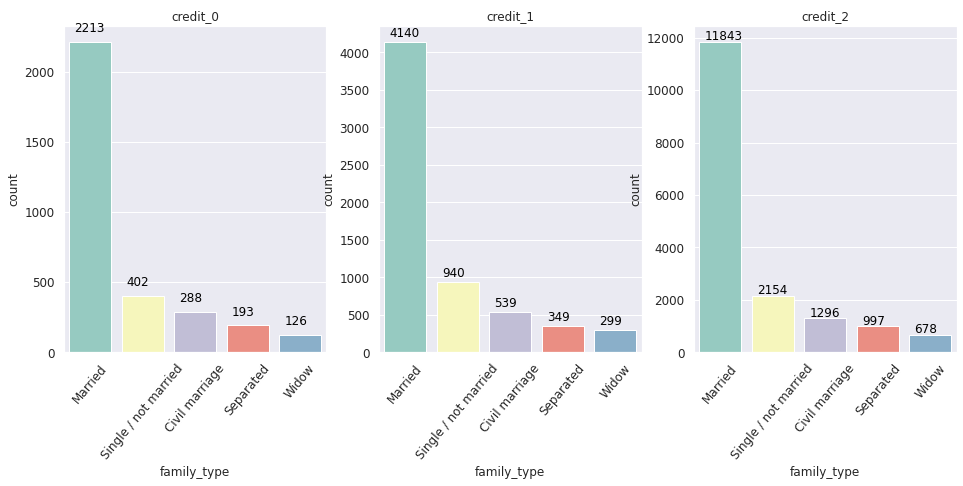

In [25]:
multicat_plot(train, 'family_type')

* 신용 등급에 따른 가족 유형은 유사해 보인다.

(8) 신용 등급과 생활 방식

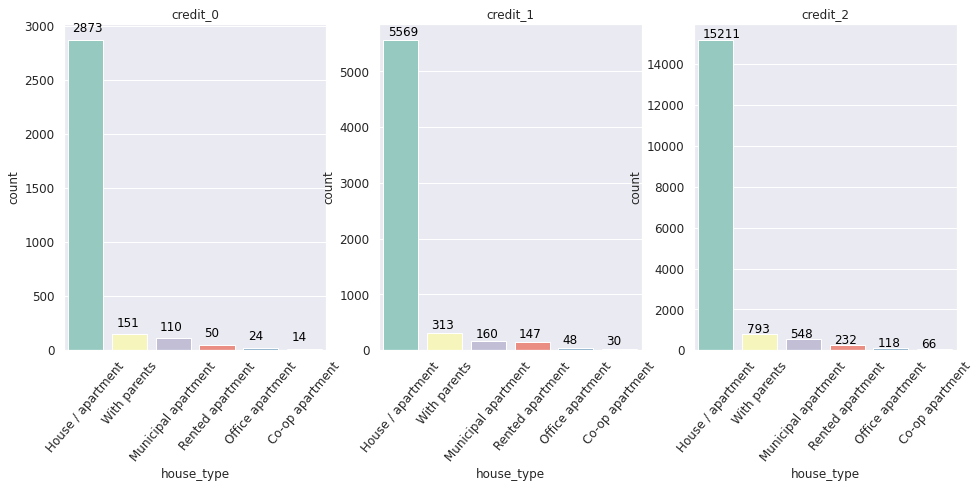

In [26]:
multicat_plot(train, 'house_type')

* 신용 등급에 따른 생활 방식은 유사해 보인다.


(9) 신용 등급과 회사 전화 유무

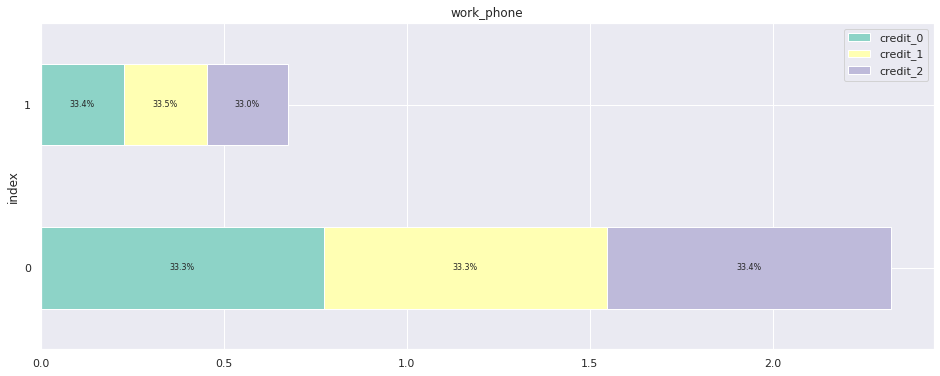

In [27]:
bar_chart(train,'work_phone')

(10) 신용 등급과 이메일 소유

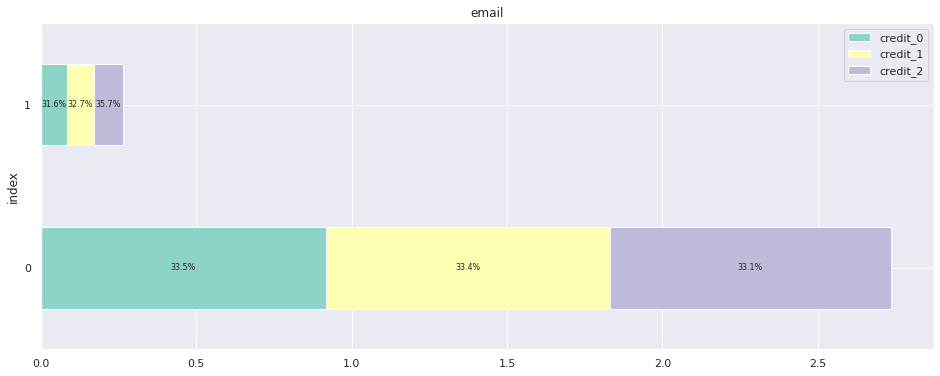

In [28]:
bar_chart(train,'email')

(11) 신용 등급과 직업 유형

In [29]:
def multicat_plot_T(data,feature):

  f, ax = plt.subplots(1, 3, figsize=(16, 10))

  credit_0 = data[data['credit']==0]
  credit_1 = data[data['credit']==1]
  credit_2 = data[data['credit']==2]

  
  sns.countplot(y = feature,
                data = credit_0,
                ax = ax[0],
                order = credit_0[feature].value_counts().index) # 큰 수부터 정렬
  
  
  ax[0].tick_params(labelsize=12)
  ax[0].set_title('credit_0')
  ax[0].set_xlabel('count')
  


  sns.countplot(y = feature,
                data = credit_1,
                ax = ax[1],
                order = credit_1[feature].value_counts().index) 
  
  
  ax[1].tick_params(labelsize=12)
  ax[1].set_title('credit_1')
  ax[1].set_xlabel('count')
  
  sns.countplot(y = feature,
                data = credit_2,
                ax = ax[2],
                order = credit_2[feature].value_counts().index)
  
  
  ax[2].tick_params(labelsize=12)
  ax[2].set_title('credit_2')
  ax[2].set_xlabel('count')
  plt.subplots_adjust(wspace=1.2, hspace=0.3)

  plt.show()


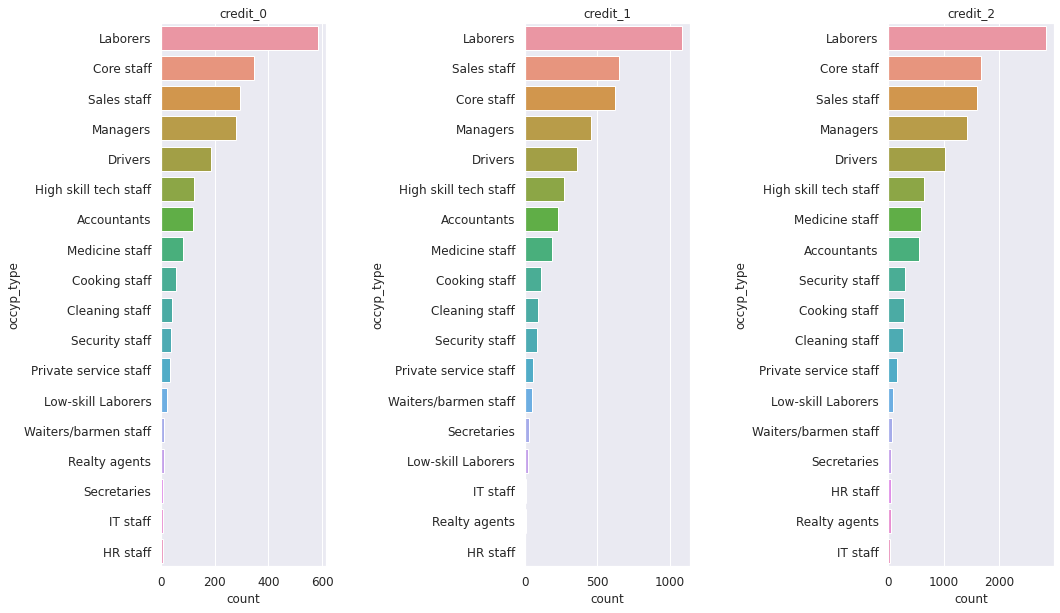

In [30]:
multicat_plot_T(train,'occyp_type')

### 연속형 변수 시각화

In [31]:
sns.set_palette("Dark2")

def num_plot(data,feature):

  f, ax = plt.subplots(1, 3, figsize=(16, 6))

  credit_0 = data[data['credit']==0]
  credit_1 = data[data['credit']==1]
  credit_2 = data[data['credit']==2]

  sns.distplot(x = credit_0[feature], ax = ax[0],
               kde=True, rug=True )
  
  ax[0].tick_params(labelsize=12)
  ax[0].set_title('credit_0')
  ax[0].set_xlabel(feature)



  sns.distplot(x = credit_1[feature],
                ax = ax[1],
               kde=True, rug=True )
  
  ax[1].tick_params(labelsize=12)
  ax[1].set_title('credit_1')
  ax[1].set_xlabel(feature)



  sns.distplot(x = credit_2[feature],
                ax = ax[2],
               kde=True, rug=True )
  
  ax[2].tick_params(labelsize=12)
  ax[2].set_title('credit_2')
  ax[2].set_xlabel(feature)


  plt.subplots_adjust(wspace=0.2, hspace=0.3)
  plt.show()

def dist_plot(data,feature): 

  credit_0 = data[data['credit']==0]
  credit_1 = data[data['credit']==1]
  credit_2 = data[data['credit']==2]

  sns.distplot(credit_0[feature],label='credit_0', hist=False, rug=True)
  sns.distplot(credit_1[feature],label='credit_1', hist=False, rug=True)
  sns.distplot(credit_2[feature],label='credit_2', hist=False, rug=True)


  plt.legend()
  plt.show()



(1) 신용 등급과 아이 수 

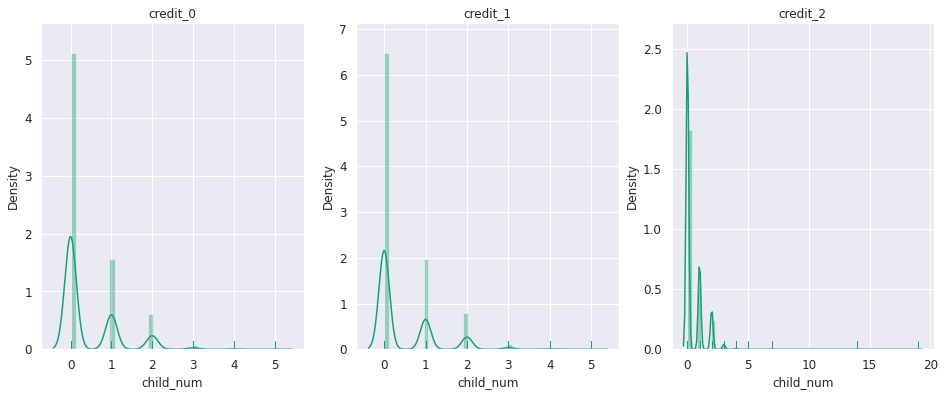

In [32]:
num_plot(train, 'child_num')

신용 등급이 낮을수록 아이의 수가 많은 듯이 보이지만, 데이터 양이 적다.

(2) 신용 등급과 전체 소득 

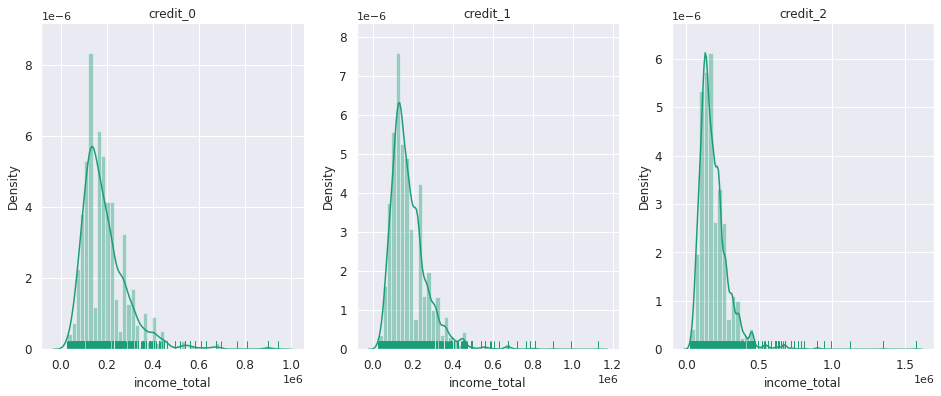

In [33]:
num_plot(train, 'income_total')

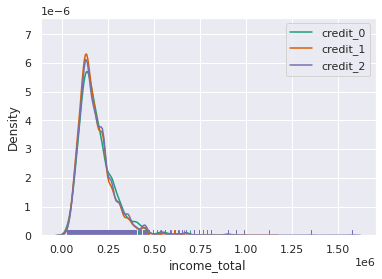

In [34]:
dist_plot(train,'income_total')

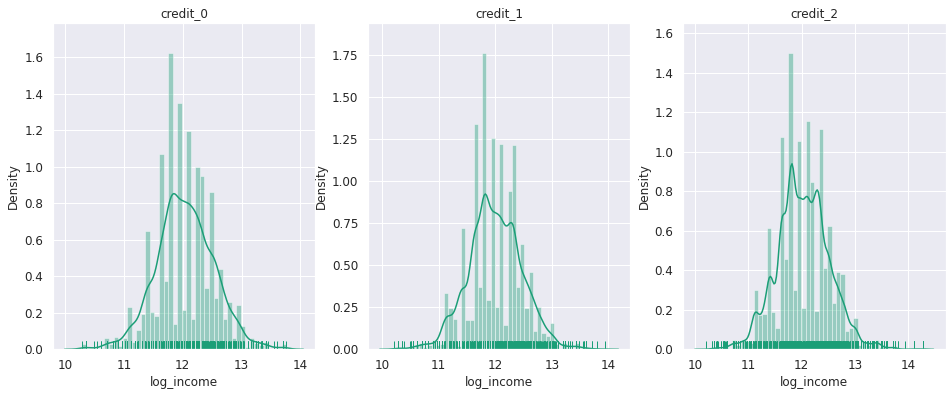

In [35]:
train['log_income'] = np.log1p(1+train['income_total'])
num_plot(train, 'log_income')

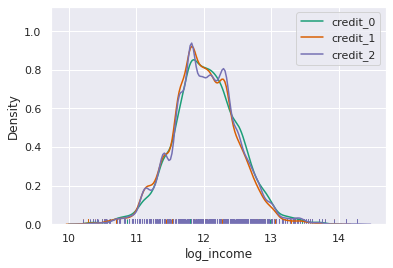

In [36]:
dist_plot(train,'log_income')
train = train.drop(columns=['log_income'])

- 상대적 비율 차이 확인 - 뚜렷한 차이는 보이지 않는다.

(3) 신용 등급과 나이 

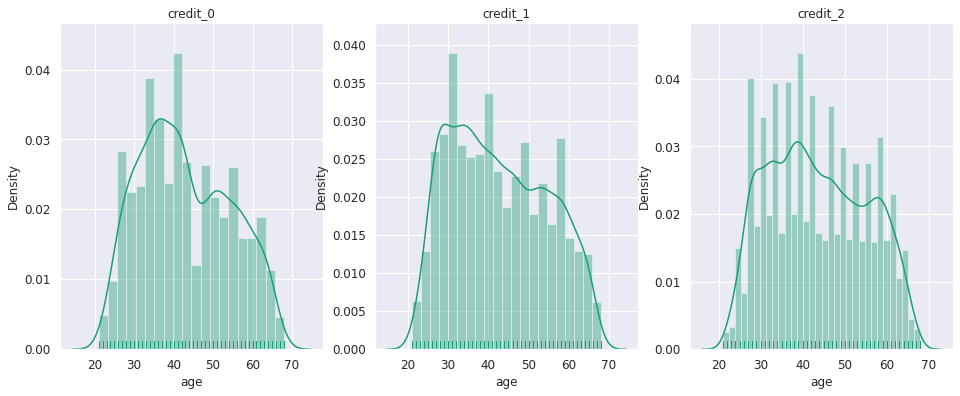

In [37]:
num_plot(train,'age')

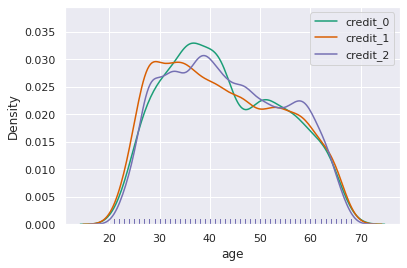

In [38]:
dist_plot(train,'age')

(4) 신용 등급과 업무 시작일

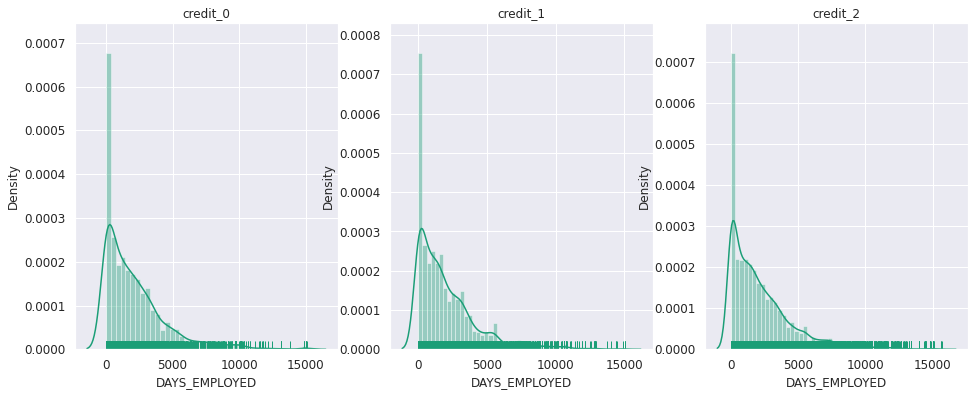

In [39]:
num_plot(train, 'DAYS_EMPLOYED')

(5) 신용 등급과 가족 수

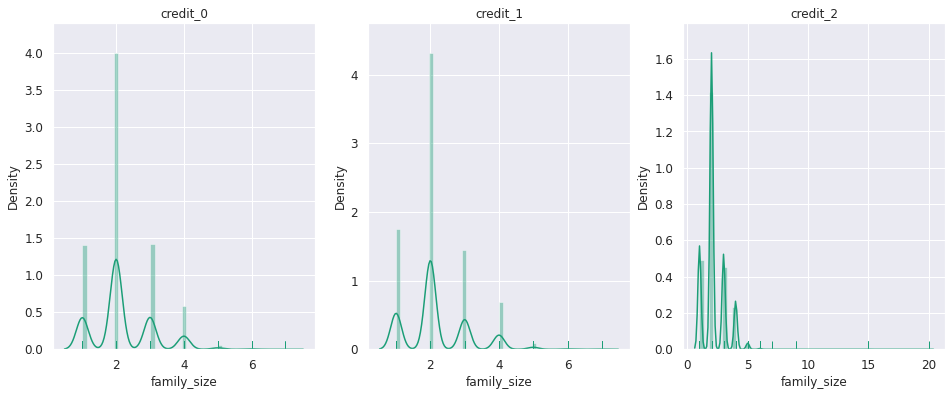

In [40]:
num_plot(train,'family_size')

(6) 신용 등급과 카드 발급월

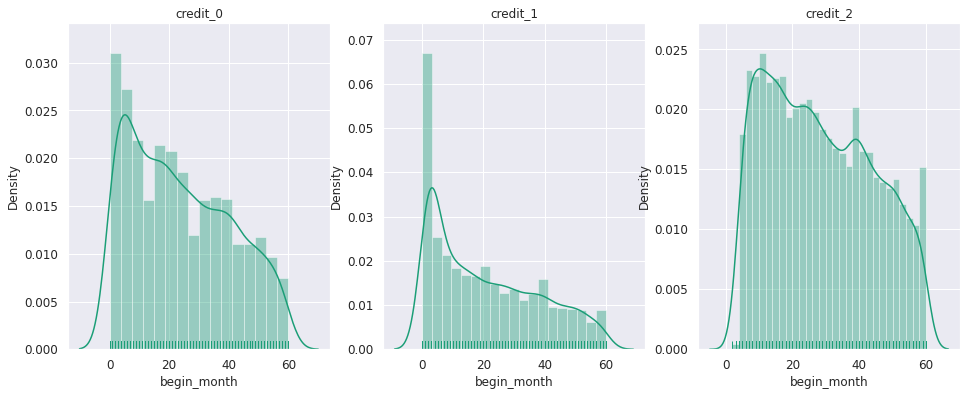

In [41]:
num_plot(train,'begin_month')

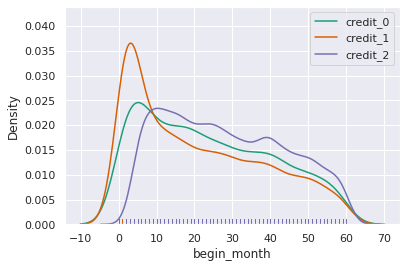

In [42]:
dist_plot(train,'begin_month')

* 가입한 지 얼마 되지 않는 사람들이 주로 신용 등급이 1임을 알 수 있다.

### 파생변수 생성

In [43]:
for df in [train,test]:
    #income_mean: 소득/ 가족 수
    df['income_respon'] = df['income_total'] / df['family_size'] # 책임, 많은 돈
    
    # ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악
    #         (begin_month, index, FLAG_MOBIL을 제거한) 16개 변수 사용
    #         한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외

    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

    df['log_income'] = np.log1p(1+df['income_total'])

    df['EM_zero_long']=df[df['DAYS_EMPLOYED']==0]['begin_month'].map(lambda x:1 if x>=10 else 0)
    df['EM_zero_long'] = df['EM_zero_long'].fillna(0)
    df['no_work_period']=df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']

    df['EMPLOYED_BIRTH_RATIO'] = df['DAYS_EMPLOYED']/df['DAYS_BIRTH'] # 아르바이트 or 최근에 직장 옮김
    df['occyp_type'] = df['occyp_type'].fillna('NAN')


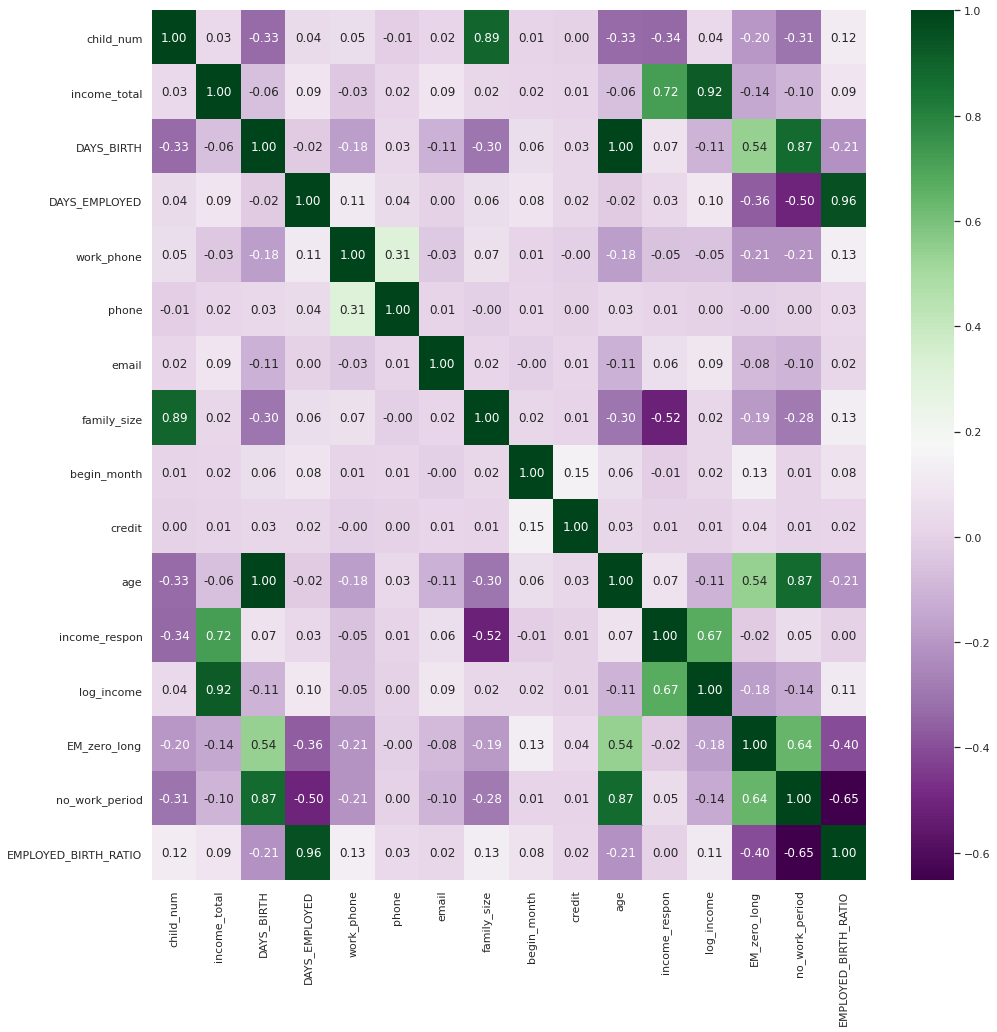

In [44]:
fig, ax = plt.subplots(figsize=(16,16))  
ax = sns.heatmap(train.corr(),annot=True,fmt='.2f',cmap="PRGn")

- 다중 공선성이 나타나는 child_num, DAYS_BIRTH, income_total 제거


In [45]:
cols = ['child_num', 'DAYS_BIRTH','income_total']
train = train.drop(columns=cols)
test = test.drop(columns=cols)

### CatBoost 모델링

- Catboost에서는 Category features를 정의하면 자동으로 변환해 사용 가능

In [46]:
from sklearn.preprocessing import LabelEncoder
labelenc = LabelEncoder()
train['ID'] = labelenc.fit_transform(train['ID'])

# 기존에 존재하지 않던 ID는 신규 클래스로 추가
for label in np.unique(test['ID']):
    if label not in labelenc.classes_: 
        labelenc.classes_ = np.append(labelenc.classes_, label)

test['ID'] = labelenc.transform(test['ID'])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [47]:
float_feats = train.dtypes[train.dtypes == "float64"].index.tolist()
for x in float_feats : 
  train[x] = train[x].astype('int64')

float_feats = test.dtypes[test.dtypes == "float64"].index.tolist()
for x in float_feats : 
  test[x] = test[x].astype('int64')

In [48]:
tr_y = train['credit']
tr_X = train.drop(columns=['credit'])

In [49]:
seed = 42
n_fold = 15
n_class = 3
cat_cols = ['gender', 'car', 'reality','income_type', 'edu_type','family_type','work_phone', 'phone', 'email','house_type','occyp_type','ID','EM_zero_long']

In [50]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(tr_X, tr_y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((tr_X.shape[0], n_class))
cat_pred_test = np.zeros((test.shape[0], n_class))
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = tr_X.iloc[train_idx], tr_X.iloc[valid_idx], tr_y[train_idx], tr_y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100) # 100번 반복할 때마다 점수 알림
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(test) / n_fold
  
print(f'\nLog Loss: {log_loss(tr_y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.115128
0:	learn: 1.0352490	test: 1.0337417	best: 1.0337417 (0)	total: 163ms	remaining: 2m 42s
100:	learn: 0.7060872	test: 0.6586572	best: 0.6585540 (89)	total: 8.49s	remaining: 1m 15s
200:	learn: 0.6884249	test: 0.6572803	best: 0.6571089 (171)	total: 18.2s	remaining: 1m 12s
300:	learn: 0.6731232	test: 0.6564446	best: 0.6558393 (287)	total: 28.2s	remaining: 1m 5s
400:	learn: 0.6578731	test: 0.6558718	best: 0.6553468 (334)	total: 38.7s	remaining: 57.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6553467683
bestIteration = 334

Shrink model to first 335 iterations.

----------------- Fold 1 -----------------

Learning rate set to 0.115128
0:	learn: 1.0351206	test: 1.0344268	best: 1.0344268 (0)	total: 120ms	remaining: 1m 59s
100:	learn: 0.7074029	test: 0.6561223	best: 0.6560851 (94)	total: 8.76s	remaining: 1m 17s
200:	learn: 0.6903117	test: 0.6523896	best: 0.6523473 (199)	total: 18.6s	remaining: 1m

Text(0.5, 1.0, 'Feature importance')

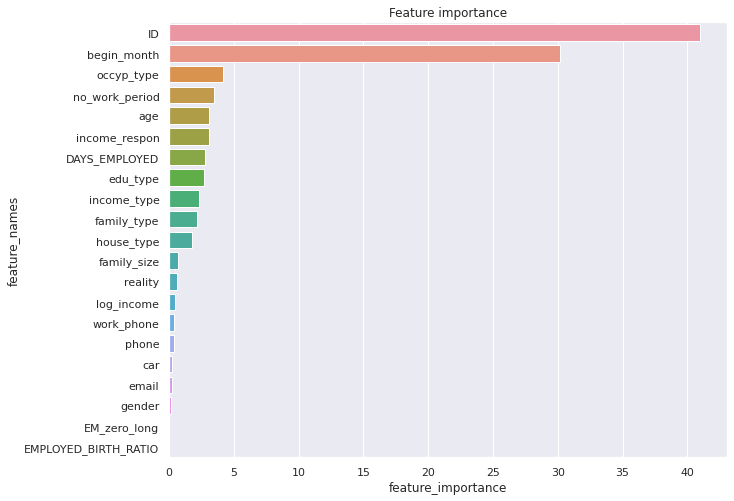

In [51]:
feature_importance = np.array(model_cat.get_feature_importance())
feature_names = np.array(tr_X.columns)

data={'feature_names':feature_names,'feature_importance':feature_importance}
data = pd.DataFrame(data)
data.sort_values(by=['feature_importance'], ascending=False,inplace=True)

plt.figure(figsize=(10,8))
sns.barplot(x=data['feature_importance'], y=data['feature_names'])
plt.title('Feature importance')


In [56]:
submission.iloc[:,1:] = cat_pred_test

In [58]:
submission.to_csv('credit_catboost.csv',index=False)